# Amazon Review Sentiment Analysis

In [1]:
!pip install torch=='2.1.0'
!pip install torchtext==0.16.0
!pip install gensim
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import collections
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

from datasets import load_dataset # hugging face
from gensim.models import KeyedVectors
import torch
from torch import nn
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from google.colab import drive
drive_path = '/content/drive'
drive.mount(drive_path)

Mounted at /content/drive


## Data preparation

In [2]:
train_data = load_dataset("amazon_polarity", split='train[:10%]')
train_data = train_data.map(lambda x: {"text_length": len(x['content'].split())})
val_data = load_dataset("amazon_polarity", split='test[:10%]')
val_data = val_data.map(lambda x: {"text_length": len(x['content'].split())})
train_data, val_data

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.81k [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/260M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/258M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/254M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Map:   0%|          | 0/360000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

(Dataset({
     features: ['label', 'title', 'content', 'text_length'],
     num_rows: 360000
 }),
 Dataset({
     features: ['label', 'title', 'content', 'text_length'],
     num_rows: 40000
 }))

In [3]:
# custom dataset
class AmazonPolarityDataset(Dataset):
    def __init__(self, dataset):
        self.data = dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text = item['content']
        label = item['label']

        return label, text

In [4]:
train_dataset = AmazonPolarityDataset(train_data)
val_dataset = AmazonPolarityDataset(val_data)

## Data Inspection

### Proportion of each sentiment

In [5]:
data = train_dataset.data[:10]
print(f"Label: {data['label']}")
print(f"Text: {data['content']}")

Label: [1, 1, 1, 1, 1, 1, 0, 1, 1, 1]
Text: ['This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^', "I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.", 'This soundtrack is my favorite music of all time, hands down. The intense sadness 

In [6]:
# 0 for negative, 1 for positive
collections.Counter(train_data['label'])

Counter({1: 182351, 0: 177649})

### Distribution of Words in Sentences

<Axes: xlabel='text_length', ylabel='Count'>

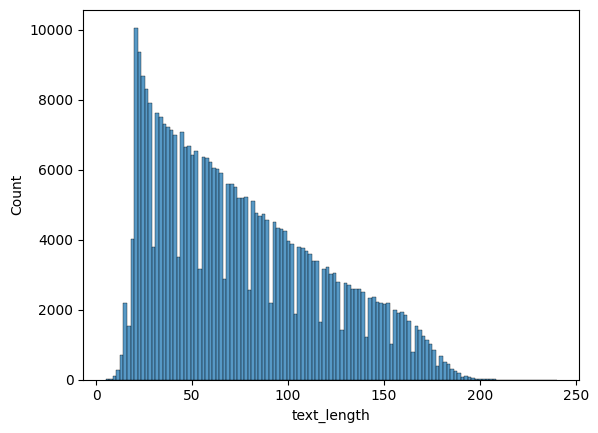

In [7]:
sns.histplot(train_data.to_pandas()['text_length'])

## Data Loader

To make a dataloader, 3 preprocessing steps are required:
1. tokinization
2. transform a list of tokens into a list of indices in the vocab dictionary
3. add padding to let each sentence have the same length of words.


In [8]:
for item in train_data:
  print(item)
  print(item['label'])
  print(float(item['label']))
  break

{'label': 1, 'title': 'Stuning even for the non-gamer', 'content': 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^', 'text_length': 75}
1
1.0


In [9]:
def collate_batch(batch, vocab, tokenizer):
  """
  Optimized collate fuction to process texts into tokenized tensors and labels.

  Args:
    dataset: The entire dataset (list of tuples [(label, text)])
    vocab: Vocabulary mapping for token-to-index conversion
    tokenizer: Tokenizer function

  Returns:
    label_tensor: Tensor containing labels
    text_tensor: Padded tensor containing tokenized texts
  """
  text_tensor = []
  label_list = []

  for item in batch:

    label = item['label']
    text = item['content']

    # tokinize and convert tokens to indices
    tokenized_text = [vocab[token] for token in tokenizer(text)]
    text_tensor.append(torch.tensor(tokenized_text))
    label_list.append(float(label))

  # padding
  text_tensor = pad_sequence(text_tensor, batch_first=True, padding_value=0)

  # convert labels to tensor
  label_tensor = torch.tensor(label_list).unsqueeze(1)

  return label_tensor, text_tensor

In [10]:
# set tokenizer
tokenizer = get_tokenizer('basic_english')

# vocab
def yield_tokens(data_iter):
  for text in data_iter:
    yield tokenizer(text['content'])


vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, collate_fn=partial(collate_batch, vocab=vocab, tokenizer=tokenizer), shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, collate_fn=partial(collate_batch, vocab=vocab, tokenizer=tokenizer), shuffle=False)

In [11]:
test_vocab = build_vocab_from_iterator(yield_tokens(train_data))
test_vocab.get_itos()[:5]

['.', 'the', ',', 'i', 'and']

In [12]:
# review sample data
sample_label, sample_data = next(iter(train_loader))
print(f'Label size: {len(sample_label)}')
print(f'Text shape: {sample_data.shape}')

Label size: 128
Text shape: torch.Size([128, 236])


## Word Embedding Matrix

The pretrained word vector model from [GoogleNews-vectors-negative300.bin](https://code.google.com/archive/p/word2vec/) is used.
>This model contains 300-dimensional vectors for 3 million words and phrases.<br>


In [13]:
word2vec = KeyedVectors.load_word2vec_format(f'{drive_path}/Othercomputers/My Laptop/shared/GoogleNews-vectors-negative300.bin', binary=True)

In [14]:
word2vec.vectors.shape

(3000000, 300)

In [15]:
vocab_size = len(vocab) # length of dictionary
embedding_dim = 300 # hyperparameter

# vectors for unknown words
unk_vectors = torch.from_numpy(np.mean(word2vec.vectors, axis=0))  # word2vec (num__words, 300) -> take mean in the axis of num_words

# create embedding matrix
embedding_matrix = torch.zeros(vocab_size, embedding_dim)
for i, word in enumerate(vocab.get_itos()):
  if word in word2vec:
    embedding_matrix[i] = torch.from_numpy(word2vec[word])
  else:
    embedding_matrix[i] = unk_vectors

<ipython-input-15-af3946567c4e>:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  embedding_matrix[i] = torch.from_numpy(word2vec[word])


In [16]:
vocab_size, embedding_matrix.shape

(306528, torch.Size([306528, 300]))

## Analysis model

In [17]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, embedding_matrix=None, dropout=0.3, num_layers=1, bidirectional=False):

        super().__init__()
        self.hidden_size = hidden_size
        self.num_directions = 2 if bidirectional else 1

        # embedding layer (vocab_size x embedding_dim)
        if embedding_matrix is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False) # if freeze=True, no update
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        input_size = embedding_dim

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size*self.num_directions, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output_seq, _ = self.rnn(x)
        output_seq = output_seq[:, -1, :]
        out = self.fc(output_seq)
        out = self.dropout(out)
        return nn.Sigmoid()(out)

For binary classification,two binary cross entropies (```nn.BCELoss``` or ```nn.BCEWithLogitsLoss```) are available in Pytorch

* ```nn.BCELoss```: This requires the model's output to pass through a sigmoid activation function, converting it to a probability between 0 and 1.

* ```nn.BCEWithLogitsLoss```: This combines the sigmoid activation and the binary cross-entropy calculation into one step. It is more numerically stable and generally preferred over nn.BCELoss.

## Learning Loop

In [18]:
def train(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs, parent_dir=None, threshold=0.5):

    train_losses = []
    val_losses = []
    val_accuracies = []
    learning_rate = {}
    best_val_loss = np.inf

    for epoch in range(1, num_epochs+1):

      # model training
      model.train()

      running_train_loss = 0.0
      running_val_loss = 0.0
      running_val_acc = 0.0

      for batch, data in tqdm(enumerate(train_loader), total=len(train_loader), desc="Training", leave=False):

        labels, inputs = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        y_preds = model(inputs)

        # import pdb; pdb.set_trace()
        loss = criterion(y_preds, labels)
        loss.backward()

        optimizer.step()
        running_train_loss += loss.item()

      # model validation
      model.eval()

      for batch, data in tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation", leave=False):
        val_labels, val_inputs = data
        val_inputs = val_inputs.to(device)  # sentences.to(device) return new tensor you need to assign it
        val_labels = val_labels.to(device)
        y_val_preds = model(val_inputs)
        val_loss = criterion(y_val_preds, val_labels)
        running_val_loss += val_loss.item()

        # accuracy
        predicted_class = (y_val_preds > threshold).float()
        running_val_acc += (predicted_class == val_labels).float().sum().item() / val_labels.size(0)

      # learning logs
      train_losses.append(running_train_loss/len(train_loader))
      val_losses.append(running_val_loss/len(val_loader))
      val_accuracies.append(running_val_acc/len(val_loader))

      print(f'Epoch {epoch}:')
      print(f'  Train losses:           {train_losses[-1]: .5f}')
      print(f'  Valodation losses:      {val_losses[-1]: .5f}')
      print(f'  Validation accuracies:  {val_accuracies[-1]: .5f}')
      print(25*'==')

      learning_rate[epoch] = optimizer.param_groups[0]['lr']
      scheduler.step()

      # save model and update num. improvement counts
      if parent_dir is not None:
        if val_losses[-1] < best_val_loss:
          best_val_loss = val_losses[-1]
          # num_improv =0
          if val_accuracies[-1] > 0.80:
            torch.save(model.state_dict(), f'{parent_dir}/model_checkpoint/torch_model_state_dict_checkpoint_epoch{epoch}.pth')

    return train_losses, val_losses, val_accuracies, learning_rate

### model, prameters, optimizer, and loss function preparation

In [19]:
vocab_size = len(vocab)
num_classes = 1 # binary classes: 0 for negative, 1 for positive
embedding_dim = 300
hidden_size = 64
output_size = num_classes
learning_rate = 0.0005
num_epochs = 10
num_layers = 2

# build a model
model = LSTM(vocab_size, embedding_dim, hidden_size, output_size, embedding_matrix=embedding_matrix, num_layers=num_layers, bidirectional=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# learning scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)
criterion = nn.BCELoss()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Model training

In [20]:
parent_dir = '/content/drive/MyDrive/SentimentAnalysis'
train_losses, val_losses, val_accuracies, learning_rate = train(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs, parent_dir)

Epoch 1:
  Train losses:            0.60340
  Valodation losses:       0.30669
  Validation accuracies:   0.87992


Epoch 2:
  Train losses:            0.37301
  Valodation losses:       0.23336
  Validation accuracies:   0.91444


Epoch 3:
  Train losses:            0.33154
  Valodation losses:       0.21424
  Validation accuracies:   0.91918


Epoch 4:
  Train losses:            0.30683
  Valodation losses:       0.20904
  Validation accuracies:   0.91880


Epoch 5:
  Train losses:            0.28330
  Valodation losses:       0.21359
  Validation accuracies:   0.91783


Epoch 6:
  Train losses:            0.26543
  Valodation losses:       0.22587
  Validation accuracies:   0.91439


Epoch 7:
  Train losses:            0.25295
  Valodation losses:       0.24295
  Validation accuracies:   0.91074


Epoch 8:
  Train losses:            0.24435
  Valodation losses:       0.26609
  Validation accuracies:   0.90740


Epoch 9:
  Train losses:            0.23690
  Valodation losses:       0.27903
  Validation accuracies:   0.90415


Epoch 10:
  Train losses:            0.23413
  Valodation losses:       0.29014
  Validation accuracies:   0.90350


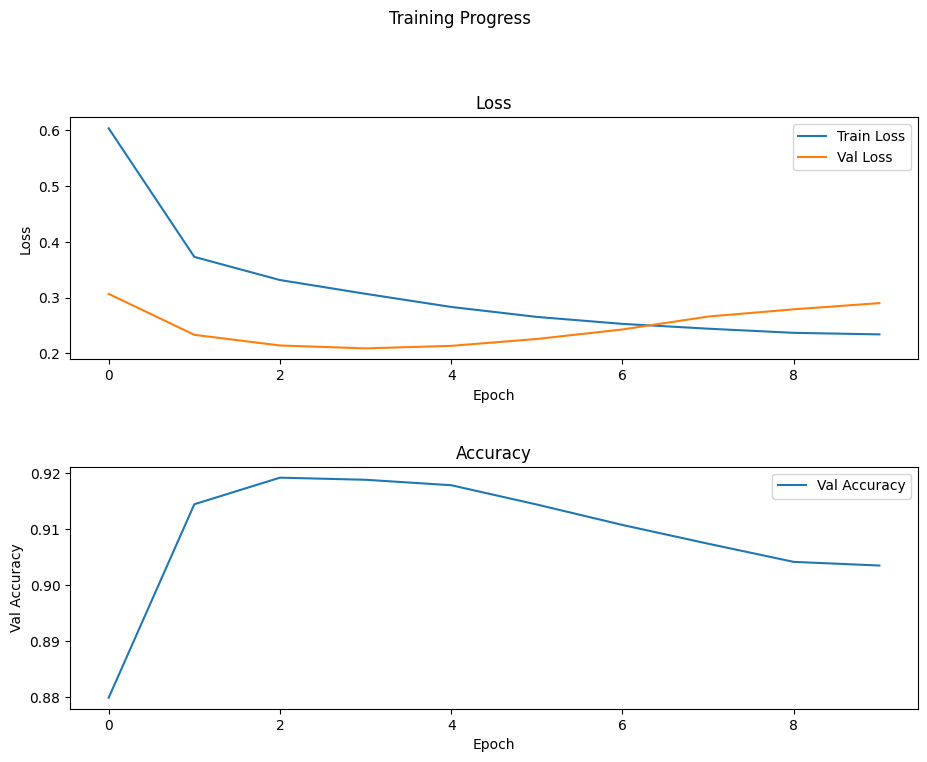

In [21]:
fig, axs = plt.subplots(2,1, figsize=(10,8))
axs[0].plot(train_losses, label='Train Loss')
axs[0].plot(val_losses, label='Val Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss')
axs[0].legend()
axs[1].plot(val_accuracies, label='Val Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Val Accuracy')
axs[1].set_title('Accuracy')
axs[1].legend()
fig.suptitle('Training Progress')
fig.tight_layout(pad=3.0)
fig.show()

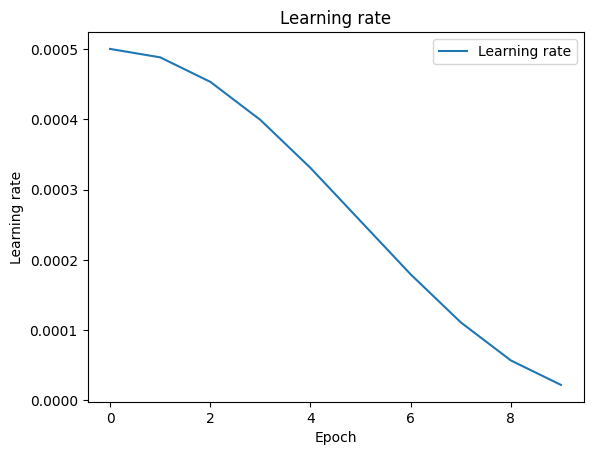

In [22]:
plt.plot(learning_rate.values(), label='Learning rate')
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.title('Learning rate')
plt.legend()

## Load Model

In [23]:
parent_dir = '/content/drive/MyDrive/SentimentAnalysis'

In [24]:
# load the best model parameters
idx = 3
model.load_state_dict(torch.load(f'{parent_dir}/model_checkpoint/torch_model_state_dict_checkpoint_epoch{idx}.pth', map_location=torch.device('cpu')))

print('Model is loaded')

Model is loaded


## Sanity test

In [26]:
# select samples from validation dataset
labels, inputs = next(iter(val_loader))
print(labels.shape, inputs.shape)

torch.Size([128, 1]) torch.Size([128, 222])


In [27]:
threshold = 0.5
model.eval()

with torch.no_grad():

  inputs = inputs.to(device)

  preds = model(inputs)
  predicted_class = (preds > threshold).float()

In [29]:
def calculate_group_percentage(cm=confusion_matrix):

  cm_flatten = cm.flatten()

  # split into two classes
  group_a, group_b = cm.flatten()[:2], cm.flatten()[2:]

  # calculate group percentage
  percentages = np.append(
      group_a/np.sum(group_a), group_b/np.sum(group_b)
      ).reshape(2,2)*100

  return percentages, group_a, group_b

def prepare_annotation_text(cm=confusion_matrix):

  percentages, group_a, group_b = calculate_group_percentage(cm)

  total_group = np.concatenate([np.repeat(np.sum(group_a),2),
                                np.repeat(np.sum(group_b),2)])

  group_names = ['True Negative','False Positive','False Negative','True Positive']
  group_counts = [f"{value}/{total}" for value, total in zip(cm.flatten(), total_group)]
  group_percentages = [f"{value:.2f}%" for value in percentages.flatten()]

  annotations = np.array([f"{name}\n\n{count}\n\n{percentage}" for name, count, percentage in
            zip(group_names,group_counts,group_percentages)]).reshape(2,2)

  # import pdb; pdb.set_trace()
  return annotations, percentages

def plot_cm(y_true, y_pred, figsize=(10,10)):

    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))

    annotations, percentages = prepare_annotation_text(cm)

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(percentages, cmap= "rocket_r", cbar_kws={'label': 'Percentage (%)'},annot=annotations, annot_kws={"fontsize":10},fmt='',ax=ax)
    plt.title('Confusion Matrix', fontsize=16, pad=20)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.xticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'], fontsize=12)
    plt.yticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'], fontsize=12)
    ax.xaxis.labelpad = 15
    ax.yaxis.labelpad = 15

Accuracy: 0.92
Precision: 0.97
Recall (Sensitivity): 0.89
F1-Score: 0.93


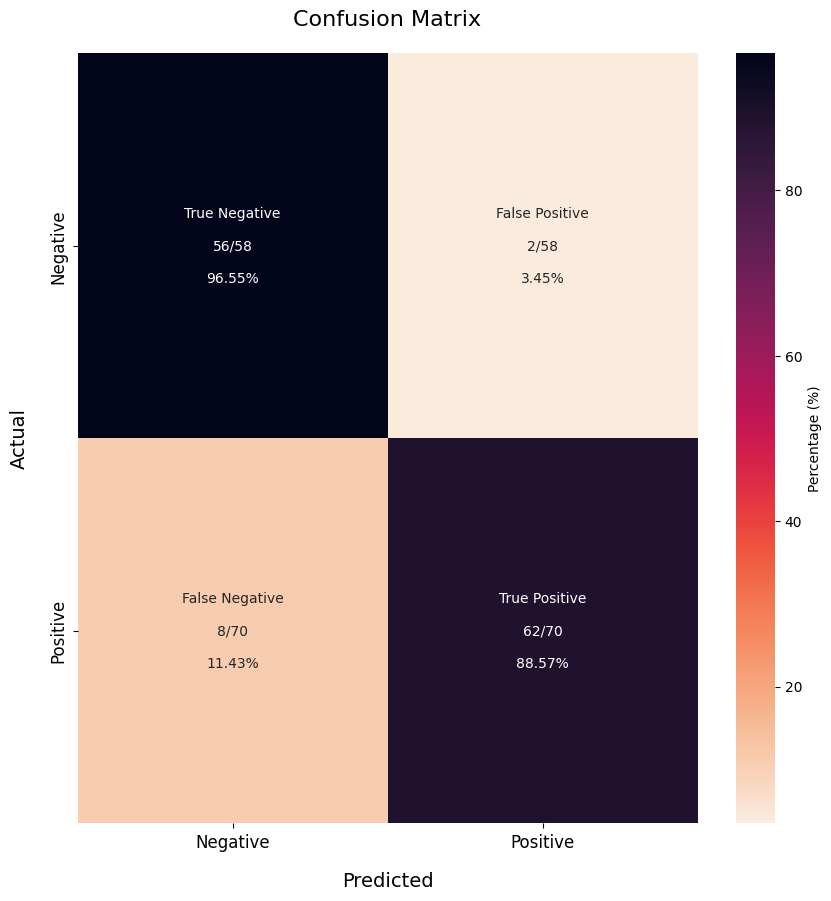

In [30]:
y_test = labels.detach().numpy().tolist()
y_pred = predicted_class.detach().cpu().numpy().tolist()

# # Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')

# Calculate recall (sensitivity)
recall = recall_score(y_test, y_pred)
print(f'Recall (Sensitivity): {recall:.2f}')

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print(f'F1-Score: {f1:.2f}')

plot_cm(y_test, y_pred)